$$\Large{\text{Machine Learning}}$$
$$\Large{\text{Applied to weather forecasting}}$$

#### Step 1: Importing libraries and setting seed

In [49]:
import pandas as pd
import numpy as np
import random
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, RidgeCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import root_mean_squared_error, r2_score

In [50]:
random.seed(42)
np.random.seed(42)

#### Step 2: Loading the data

In [51]:
file_path = "nyc_weather_2016_2022.csv"
df = pd.read_csv(file_path)

#### Step 3: Aggregating the hourly data into daily data and cleaning the data

The weather dataset that was acquired included predictors I were interested in using but recorded the weather data hourly.

The model I want to train is based on the Stanford University research paper and involves predicting the maximum and minimum temperatures for the next 7 days using a combination of predictors and lagged terms for minimum and maximum temperatures.

To be able to utilize the data more efficiently to predict daily targets, I decided to aggregate the data to transform it from hourly to daily weather data.

In [52]:
# Drop rows where all weather-related columns are NaN
df = df.dropna(subset=["temperature_2m (°C)", "precipitation (mm)", "rain (mm)", 
                       "cloudcover (%)", "windspeed_10m (km/h)"], how="all")

# Convert time column to datetime
df["time"] = pd.to_datetime(df["time"])

# Handle Nas **before aggregation** (Hourly Data)
# - Fill Nas in precipitation/rain with 0 (assuming missing = no rain)
df = df.assign(**{
    "precipitation (mm)": df["precipitation (mm)"].fillna(0),
    "rain (mm)": df["rain (mm)"].fillna(0)
})

# - Fill Nas in continuous variables with the median of each column
cols_to_fill_median = ["temperature_2m (°C)", "cloudcover (%)", 
                        "cloudcover_low (%)", "cloudcover_mid (%)", 
                        "cloudcover_high (%)", "windspeed_10m (km/h)", 
                        "winddirection_10m (°)"]

df[cols_to_fill_median] = df[cols_to_fill_median].apply(lambda x: x.fillna(x.median()))

# Extract the date (drop time part)
df["date"] = df["time"].dt.date

# Sorting rows by date
df = df.sort_values("date")

# Aggregate to daily data
daily_df = df.groupby("date").agg({
    "temperature_2m (°C)": ["max", "min", "mean"],  # Daily max, min, avg temp
    "precipitation (mm)": "sum",  # Total daily precipitation
    "rain (mm)": "sum",  # Total daily rain
    "cloudcover (%)": "mean",  # Average cloud cover
    "cloudcover_low (%)": "mean",
    "cloudcover_mid (%)": "mean",
    "cloudcover_high (%)": "mean",
    "windspeed_10m (km/h)": "mean",  # Average wind speed
    "winddirection_10m (°)": "mean"  # Average wind direction
}).reset_index()

# Rename columns
daily_df.columns = ["date", "max_temp", "min_temp", "avg_temp", "total_precip", 
                    "total_rain", "avg_cloudcover", "avg_cloudcover_low", 
                    "avg_cloudcover_mid", "avg_cloudcover_high", "avg_windspeed", 
                    "avg_winddirection"]

#### Step 4: Feature engineering

Referencing the research paper written by Mark Holmstrom, Dylan Liu and Christopher Vo at Stanford University, I decided to use the following lagged terms as predictors:

- Maximum temperature at lag 1 and lag 2
- Minimum temperature at lag 1 and lag 2

I also created additional columns for the 14 targets. (min and max temp for the next 7 days)

In [53]:
# Creating lagged features by filling the new columns with shifted values
daily_df["max_temp_lag1"] = daily_df["max_temp"].shift(1)
daily_df["max_temp_lag2"] = daily_df["max_temp"].shift(2)
daily_df["min_temp_lag1"] = daily_df["min_temp"].shift(1)
daily_df["min_temp_lag2"] = daily_df["min_temp"].shift(2)

# Create future target variables (next 7 days of min and max temperatures)
for i in range(1, 7):
    daily_df[f"min_temp_tplus{i}"] = daily_df["min_temp"].shift(-i)
    daily_df[f"max_temp_tplus{i}"] = daily_df["max_temp"].shift(-i)


# Drop rows with any NaNs from lagging and future shifting
daily_df = daily_df.dropna().reset_index(drop=True)

# Uncomment to download clean dataset with engineered features
# clean_file_path = "nyc_weather_daily_2016_2022_cleaned.csv"
# daily_df.to_csv(clean_file_path, index=False)

#### Step 5: Performing exploratory data analysis

Before performing EDA, I split the data into a training set and a testing set.

Next I explore the data to find the relationships between the target and the potential predictors.

To that end, I decided to use a pairwise plot to see how each predictor is related to the targets and to other predictors.

I also used a correlation matrix plot to show the different correlation coefficients between each pair of variables.

Furthermore I plotted several scatterplots of the target against the predictor for each of the most promising predictors.

After that I plotted histograms and density plots for most promising predictors to check for skewness and therefore for potential transformations that could be applied to the predictors or the targets.

In [54]:
# Split index (80% training)
split_idx = int(len(daily_df) * 0.8)

# Create training and testing DataFrames
df_train = daily_df.iloc[:split_idx].copy()
df_test = daily_df.iloc[split_idx:].copy()

# Checking for NA's
print(f"Training set NA count: {df_train.isna().sum().sum()}")
print(f"Testing set NA count: {df_test.isna().sum().sum()}")

Training set NA count: 0
Testing set NA count: 0


In [55]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1980 entries, 0 to 1979
Data columns (total 28 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   date                 1980 non-null   object 
 1   max_temp             1980 non-null   float64
 2   min_temp             1980 non-null   float64
 3   avg_temp             1980 non-null   float64
 4   total_precip         1980 non-null   float64
 5   total_rain           1980 non-null   float64
 6   avg_cloudcover       1980 non-null   float64
 7   avg_cloudcover_low   1980 non-null   float64
 8   avg_cloudcover_mid   1980 non-null   float64
 9   avg_cloudcover_high  1980 non-null   float64
 10  avg_windspeed        1980 non-null   float64
 11  avg_winddirection    1980 non-null   float64
 12  max_temp_lag1        1980 non-null   float64
 13  max_temp_lag2        1980 non-null   float64
 14  min_temp_lag1        1980 non-null   float64
 15  min_temp_lag2        1980 non-null   f

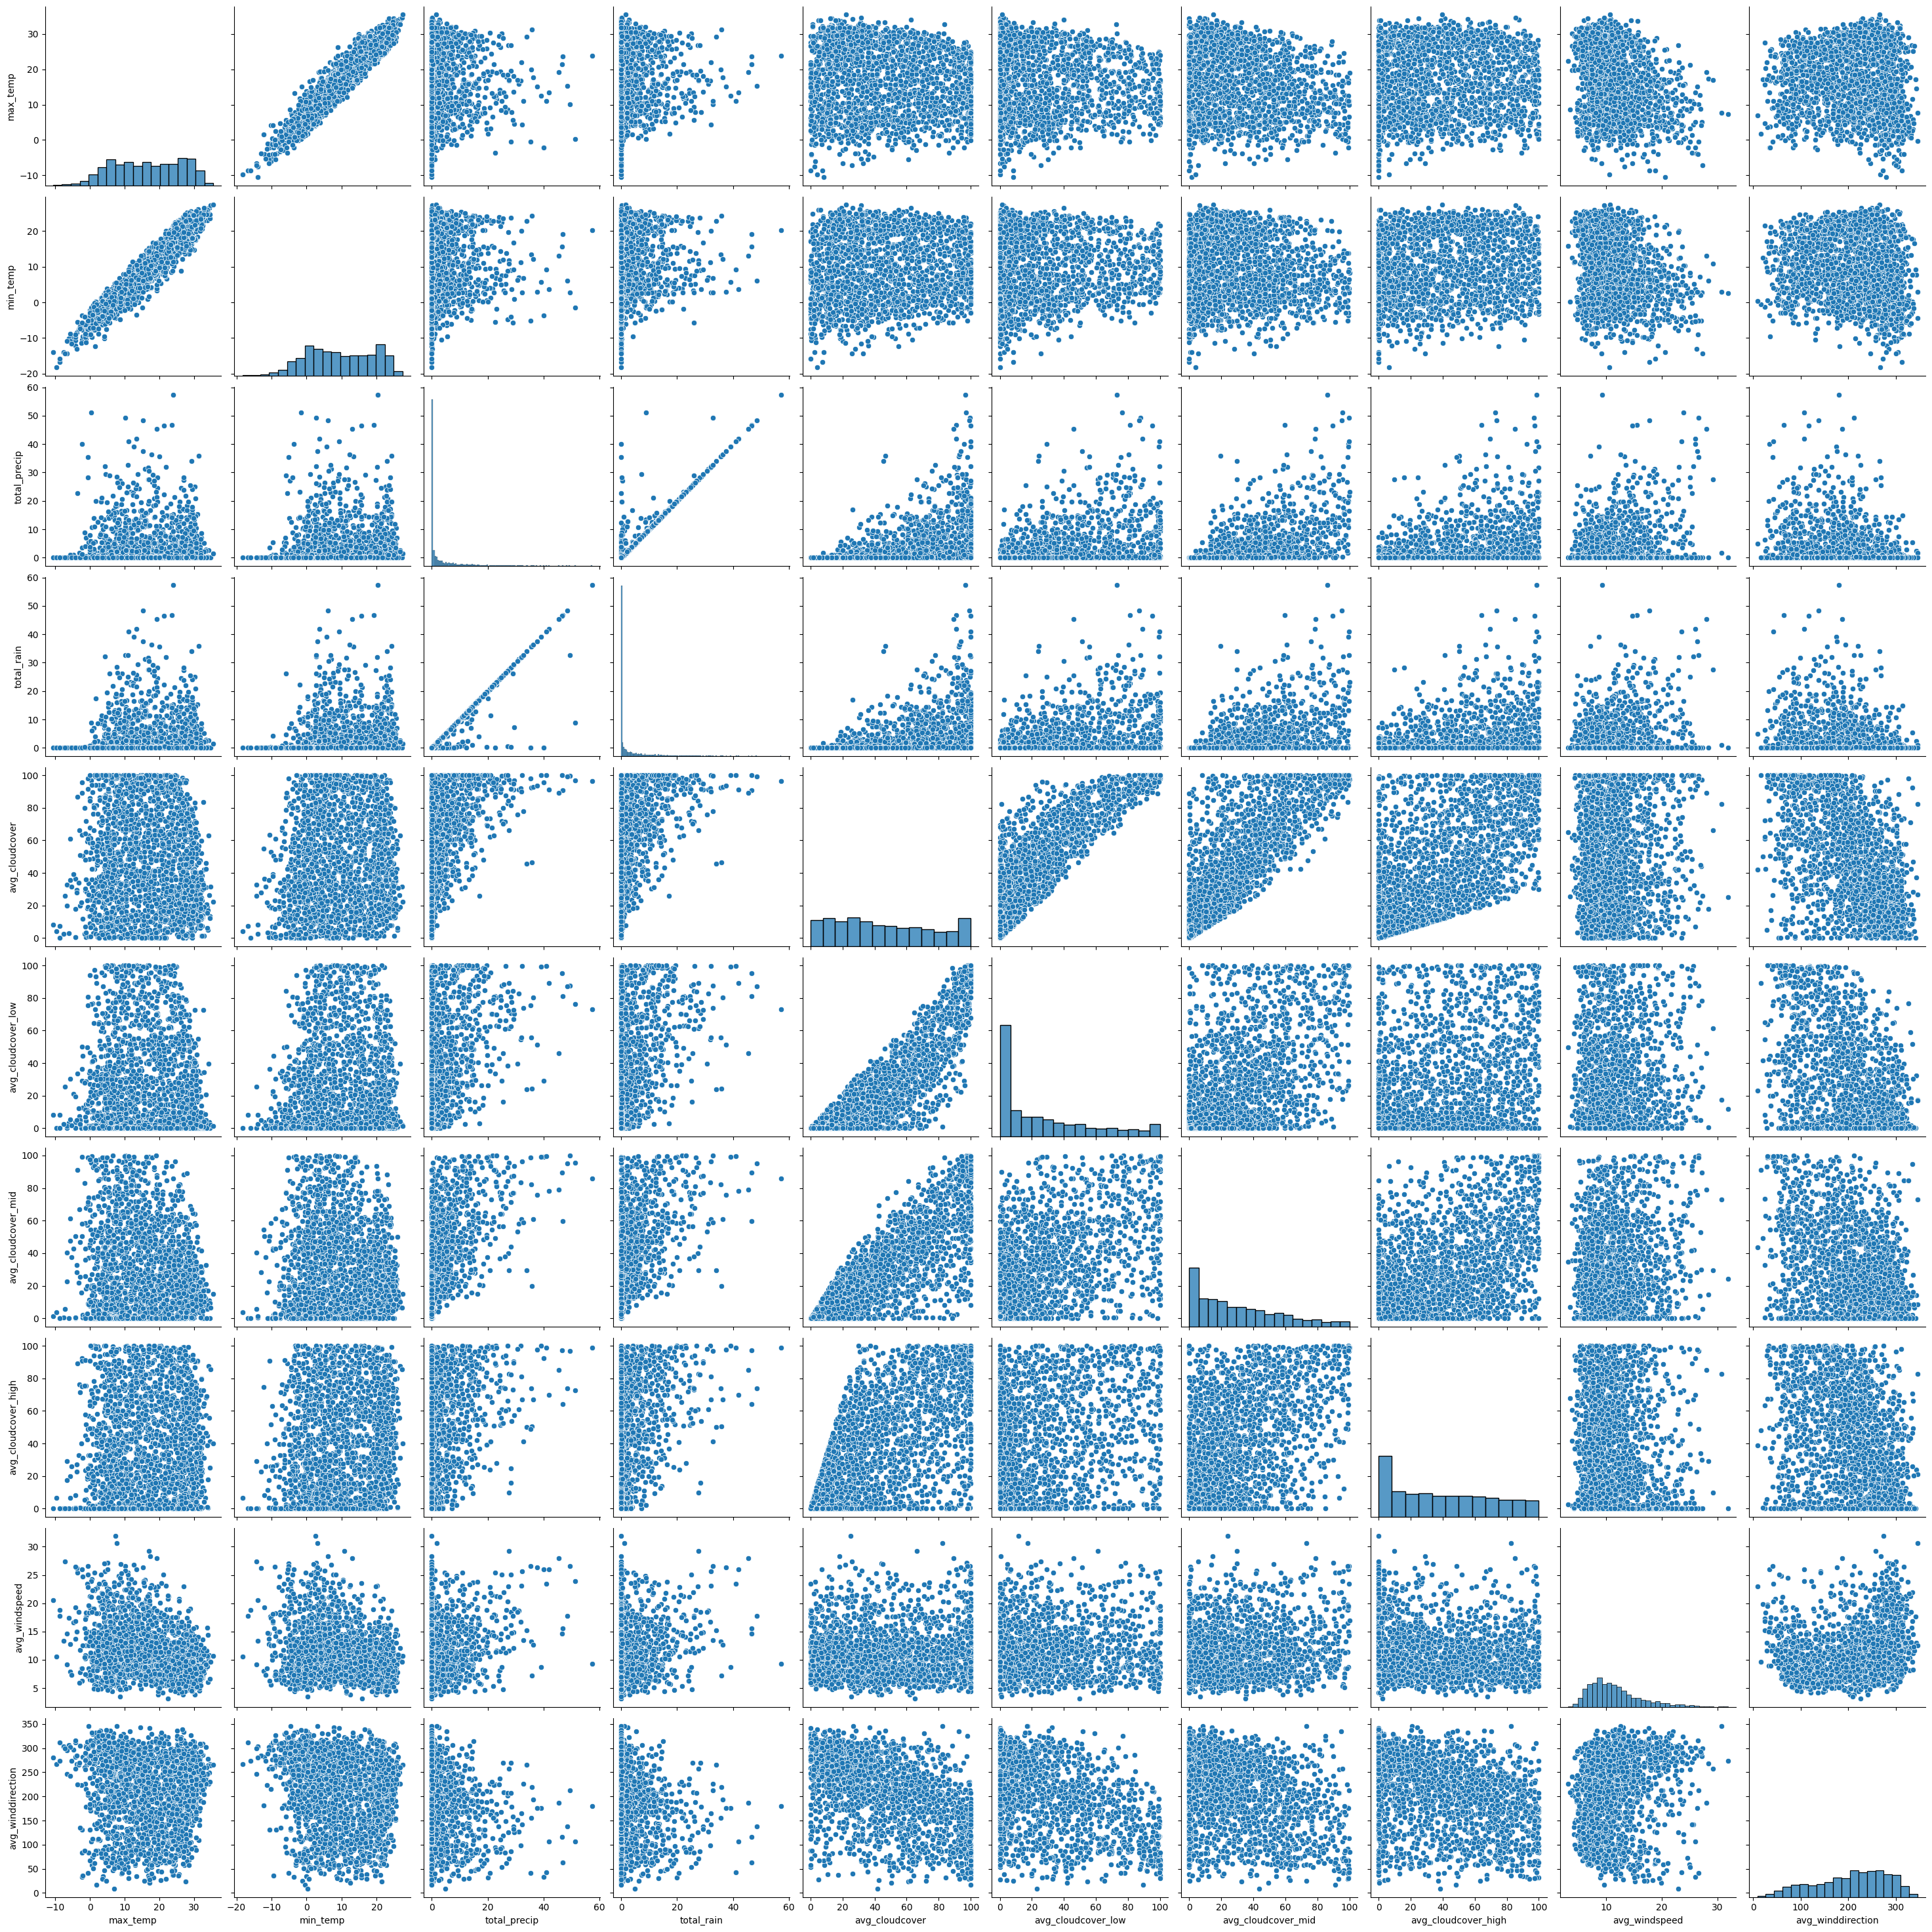

In [56]:
eda_cols_to_include = ["max_temp", "min_temp", "total_precip", 
                       "total_rain", "avg_cloudcover", "avg_cloudcover_low", 
                       "avg_cloudcover_mid", "avg_cloudcover_high",
                       "avg_windspeed", "avg_winddirection"]

sns.pairplot(df_train[eda_cols_to_include], height=3)
plt.show()

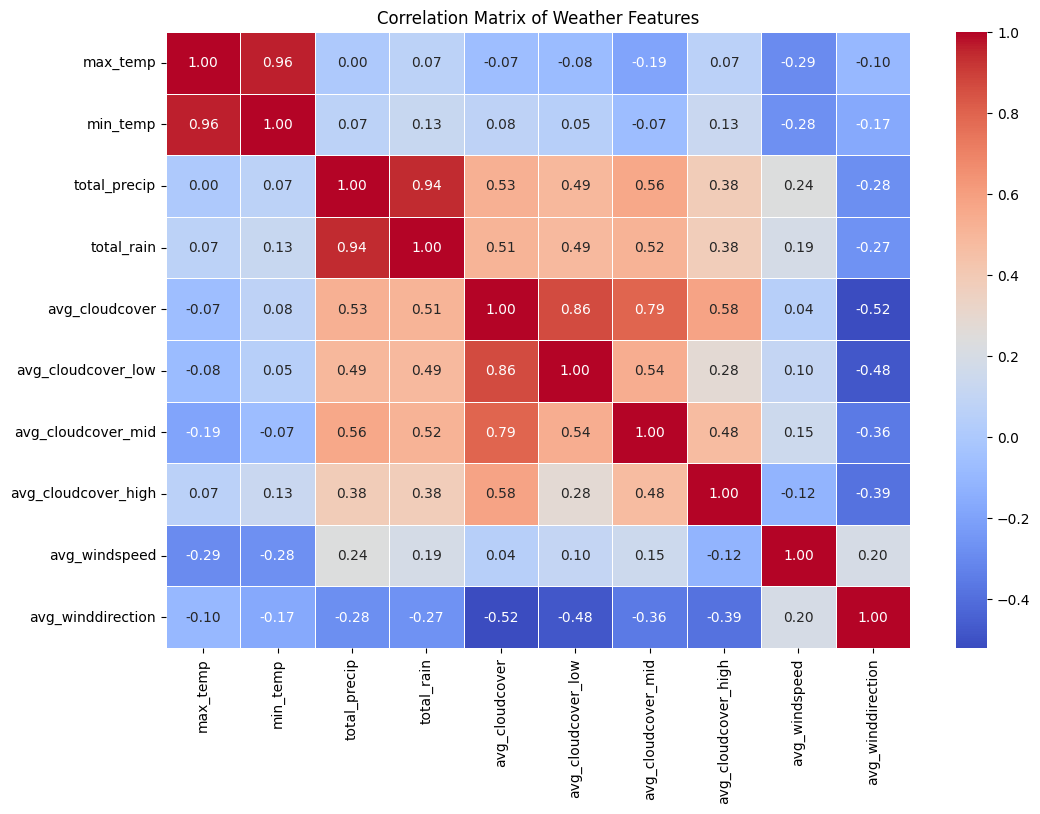

Top correlations with max_temp:
max_temp               1.000000
min_temp               0.961135
total_rain             0.068147
avg_cloudcover_high    0.066617
total_precip           0.004556
avg_cloudcover        -0.067472
avg_cloudcover_low    -0.076115
avg_winddirection     -0.097311
avg_cloudcover_mid    -0.189355
avg_windspeed         -0.293569
Name: max_temp, dtype: float64

Top correlations with min_temp:
min_temp               1.000000
max_temp               0.961135
avg_cloudcover_high    0.130748
total_rain             0.126238
avg_cloudcover         0.075053
total_precip           0.067512
avg_cloudcover_low     0.046039
avg_cloudcover_mid    -0.071470
avg_winddirection     -0.169064
avg_windspeed         -0.275739
Name: min_temp, dtype: float64


In [57]:
# Compute the correlation matrix
corr_matrix = df_train[eda_cols_to_include].corr()

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix of Weather Features")
plt.show()

# Display top correlations with max_temp and min_temp
print("Top correlations with max_temp:")
print(corr_matrix["max_temp"].sort_values(ascending=False))

print("\nTop correlations with min_temp:")
print(corr_matrix["min_temp"].sort_values(ascending=False))

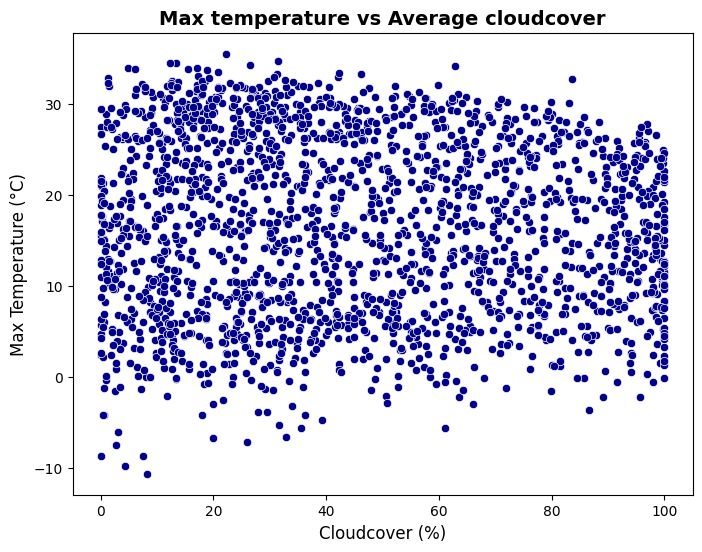

In [58]:
# Define plot size
plt.figure(figsize=(8, 6))

# Define data, axes and color
sns.scatterplot(data = df_train, x = "avg_cloudcover", 
                y = "max_temp", color = "darkblue")

# Add main title and format it
plt.title("Max temperature vs Average cloudcover", 
          fontsize=14, fontweight="bold", ha="center")

# Add axes titles and format them
plt.xlabel("Cloudcover (%)", fontsize=12)
plt.ylabel("Max Temperature (°C)", fontsize=12)

# Display the plot
plt.show()

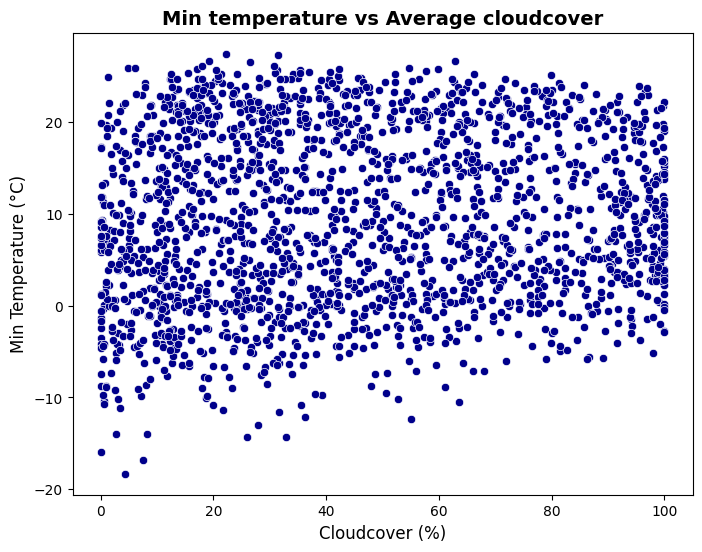

In [59]:
# Define plot size
plt.figure(figsize=(8, 6))

# Define data, axes and color
sns.scatterplot(data = df_train, x = "avg_cloudcover", 
                y = "min_temp", color = "darkblue")

# Add main title and format it
plt.title("Min temperature vs Average cloudcover", 
          fontsize=14, fontweight="bold", ha="center")

# Add axes titles and format them
plt.xlabel("Cloudcover (%)", fontsize=12)
plt.ylabel("Min Temperature (°C)", fontsize=12)

# Display the plot
plt.show()

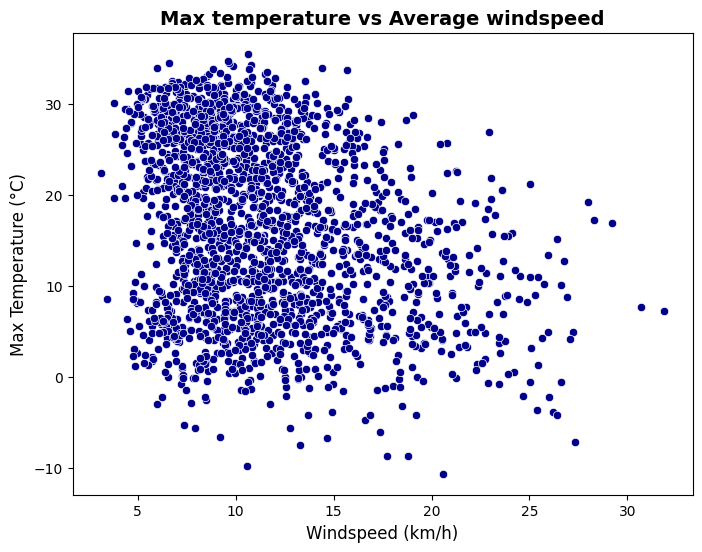

In [60]:
# Define plot size
plt.figure(figsize=(8, 6))

# Define data, axes and color
sns.scatterplot(data = df_train, x = "avg_windspeed", 
                y = "max_temp", color = "darkblue")

# Add main title and format it
plt.title("Max temperature vs Average windspeed", 
          fontsize=14, fontweight="bold", ha="center")

# Add axes titles and format them
plt.xlabel("Windspeed (km/h)", fontsize=12)
plt.ylabel("Max Temperature (°C)", fontsize=12)

# Display the plot
plt.show()

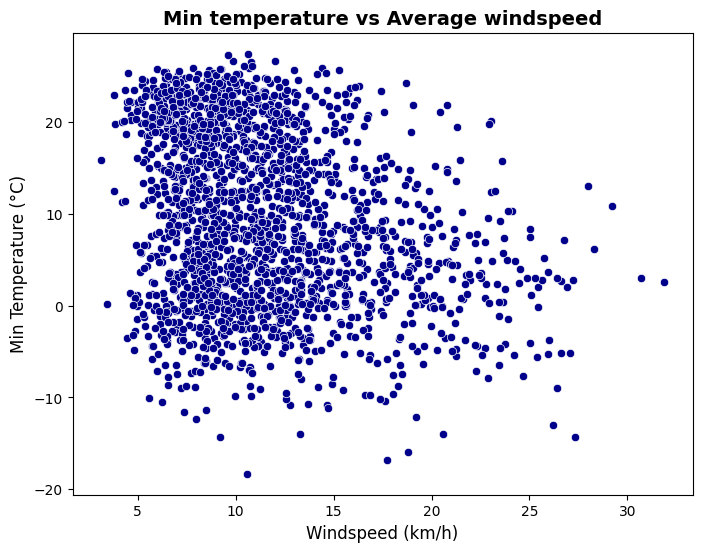

In [61]:
# Define plot size
plt.figure(figsize=(8, 6))

# Define data, axes and color
sns.scatterplot(data = df_train, x = "avg_windspeed", 
                y = "min_temp", color = "darkblue")

# Add main title and format it
plt.title("Min temperature vs Average windspeed", 
          fontsize=14, fontweight="bold", ha="center")

# Add axes titles and format them
plt.xlabel("Windspeed (km/h)", fontsize=12)
plt.ylabel("Min Temperature (°C)", fontsize=12)

# Display the plot
plt.show()

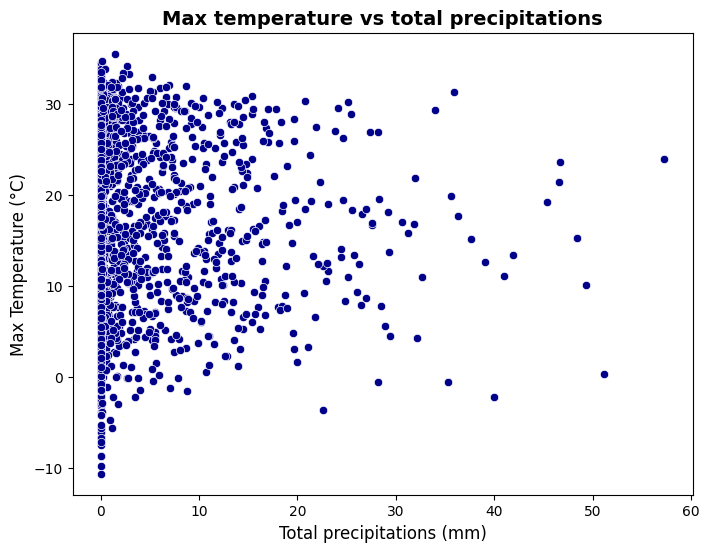

In [62]:
# Define plot size
plt.figure(figsize=(8, 6))

# Define data, axes and color
sns.scatterplot(data = df_train, x = "total_precip", 
                y = "max_temp", color = "darkblue")

# Add main title and format it
plt.title("Max temperature vs total precipitations", 
          fontsize=14, fontweight="bold", ha="center")

# Add axes titles and format them
plt.xlabel("Total precipitations (mm)", fontsize=12)
plt.ylabel("Max Temperature (°C)", fontsize=12)

# Display the plot
plt.show()

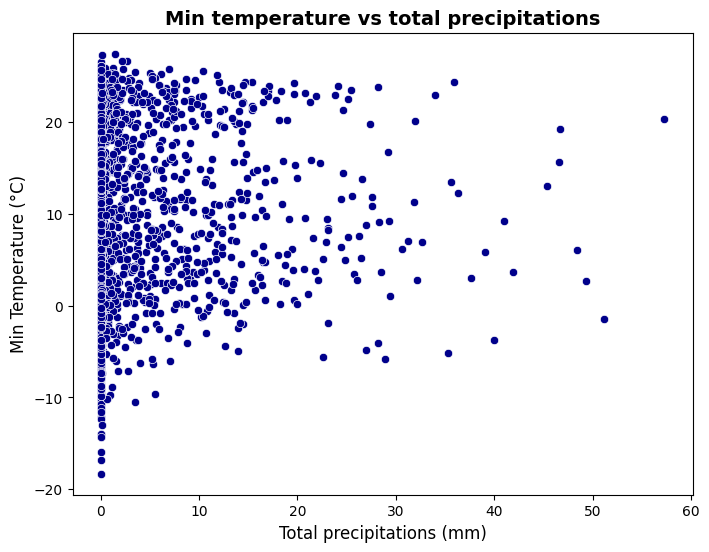

In [63]:
# Define plot size
plt.figure(figsize=(8, 6))

# Define data, axes and color
sns.scatterplot(data = df_train, x = "total_precip", 
                y = "min_temp", color = "darkblue")

# Add main title and format it
plt.title("Min temperature vs total precipitations", 
          fontsize=14, fontweight="bold", ha="center")

# Add axes titles and format them
plt.xlabel("Total precipitations (mm)", fontsize=12)
plt.ylabel("Min Temperature (°C)", fontsize=12)

# Display the plot
plt.show()

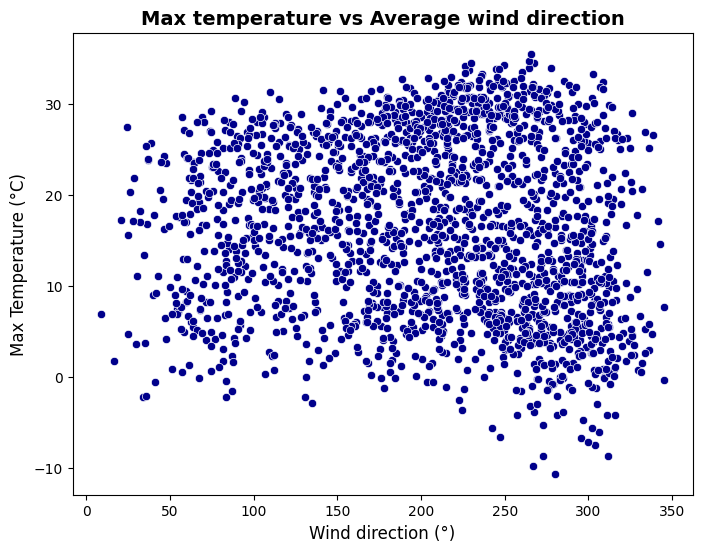

In [64]:
# Define plot size
plt.figure(figsize=(8, 6))

# Define data, axes and color
sns.scatterplot(data = df_train, x = "avg_winddirection", 
                y = "max_temp", color = "darkblue")

# Add main title and format it
plt.title("Max temperature vs Average wind direction", 
          fontsize=14, fontweight="bold", ha="center")

# Add axes titles and format them
plt.xlabel("Wind direction (°)", fontsize=12)
plt.ylabel("Max Temperature (°C)", fontsize=12)

# Display the plot
plt.show()

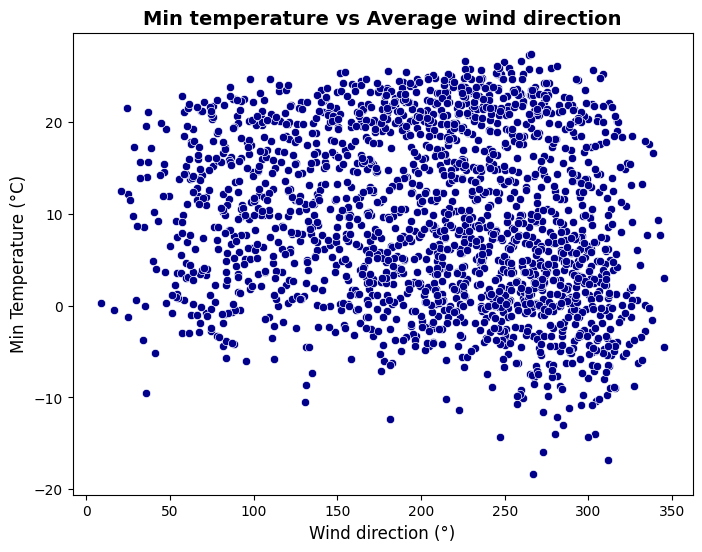

In [65]:
# Define plot size
plt.figure(figsize=(8, 6))

# Define data, axes and color
sns.scatterplot(data = df_train, x = "avg_winddirection", 
                y = "min_temp", color = "darkblue")

# Add main title and format it
plt.title("Min temperature vs Average wind direction", 
          fontsize=14, fontweight="bold", ha="center")

# Add axes titles and format them
plt.xlabel("Wind direction (°)", fontsize=12)
plt.ylabel("Min Temperature (°C)", fontsize=12)

# Display the plot
plt.show()

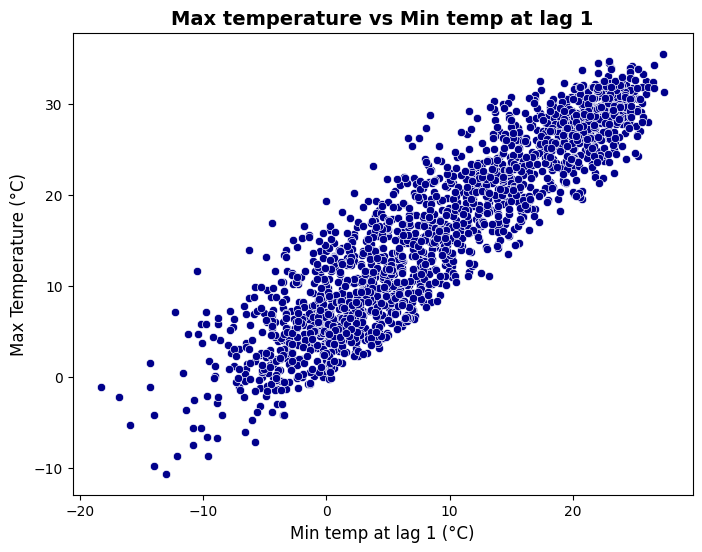

In [66]:
# Define plot size
plt.figure(figsize=(8, 6))

# Define data, axes and color
sns.scatterplot(data = df_train, x = "min_temp_lag1", 
                y = "max_temp", color = "darkblue")

# Add main title and format it
plt.title("Max temperature vs Min temp at lag 1", 
          fontsize=14, fontweight="bold", ha="center")

# Add axes titles and format them
plt.xlabel("Min temp at lag 1 (°C)", fontsize=12)
plt.ylabel("Max Temperature (°C)", fontsize=12)

# Display the plot
plt.show()

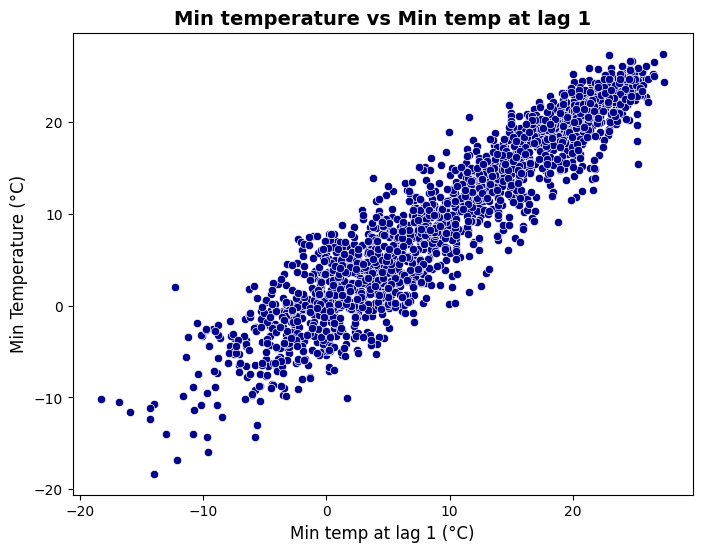

In [67]:
# Define plot size
plt.figure(figsize=(8, 6))

# Define data, axes and color
sns.scatterplot(data = df_train, x = "min_temp_lag1", 
                y = "min_temp", color = "darkblue")

# Add main title and format it
plt.title("Min temperature vs Min temp at lag 1", 
          fontsize=14, fontweight="bold", ha="center")

# Add axes titles and format them
plt.xlabel("Min temp at lag 1 (°C)", fontsize=12)
plt.ylabel("Min Temperature (°C)", fontsize=12)

# Display the plot
plt.show()

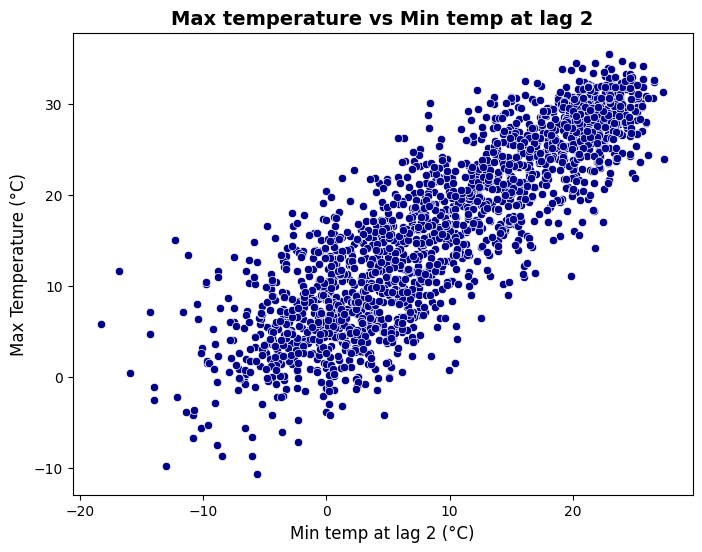

In [68]:
# Define plot size
plt.figure(figsize=(8, 6))

# Define data, axes and color
sns.scatterplot(data = df_train, x = "min_temp_lag2", 
                y = "max_temp", color = "darkblue")

# Add main title and format it
plt.title("Max temperature vs Min temp at lag 2", 
          fontsize=14, fontweight="bold", ha="center")

# Add axes titles and format them
plt.xlabel("Min temp at lag 2 (°C)", fontsize=12)
plt.ylabel("Max Temperature (°C)", fontsize=12)

# Display the plot
plt.show()

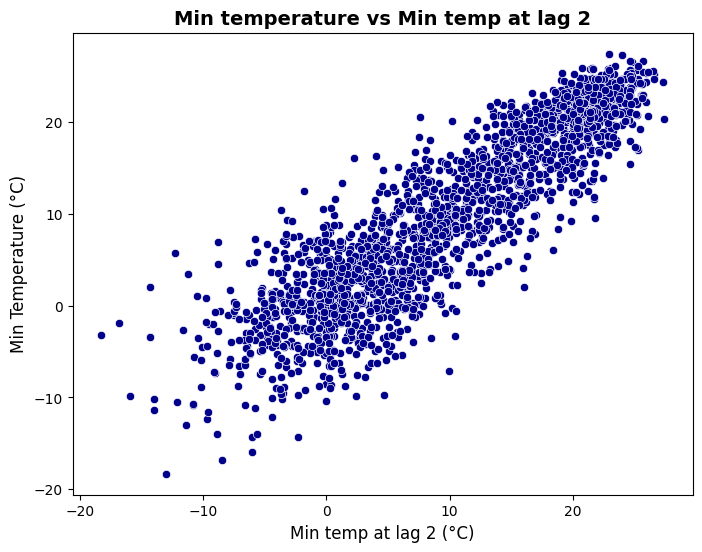

In [69]:
# Define plot size
plt.figure(figsize=(8, 6))

# Define data, axes and color
sns.scatterplot(data = df_train, x = "min_temp_lag2", 
                y = "min_temp", color = "darkblue")

# Add main title and format it
plt.title("Min temperature vs Min temp at lag 2", 
          fontsize=14, fontweight="bold", ha="center")

# Add axes titles and format them
plt.xlabel("Min temp at lag 2 (°C)", fontsize=12)
plt.ylabel("Min Temperature (°C)", fontsize=12)

# Display the plot
plt.show()

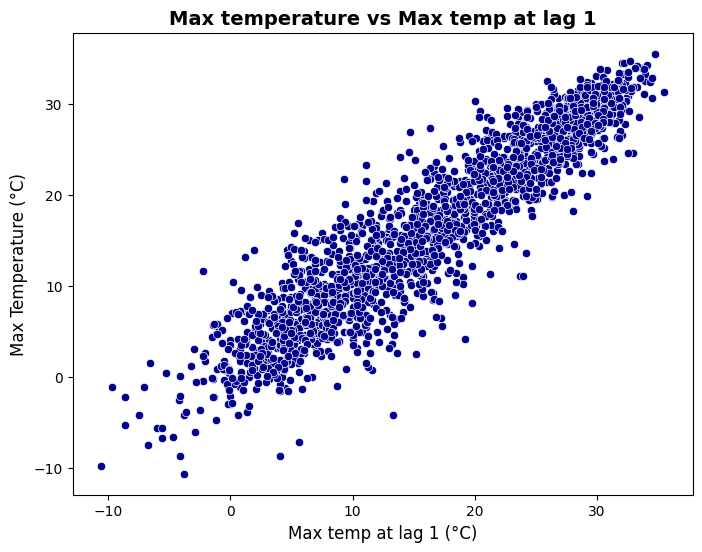

In [70]:
# Define plot size
plt.figure(figsize=(8, 6))

# Define data, axes and color
sns.scatterplot(data = df_train, x = "max_temp_lag1", 
                y = "max_temp", color = "darkblue")

# Add main title and format it
plt.title("Max temperature vs Max temp at lag 1", 
          fontsize=14, fontweight="bold", ha="center")

# Add axes titles and format them
plt.xlabel("Max temp at lag 1 (°C)", fontsize=12)
plt.ylabel("Max Temperature (°C)", fontsize=12)

# Display the plot
plt.show()

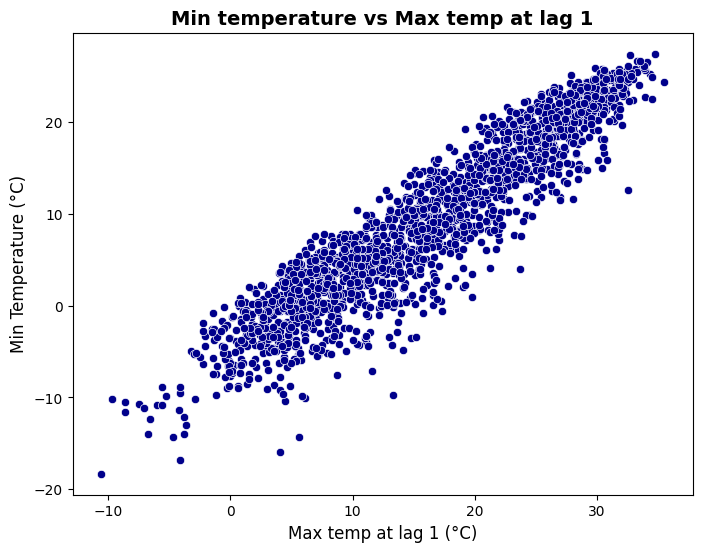

In [71]:
# Define plot size
plt.figure(figsize=(8, 6))

# Define data, axes and color
sns.scatterplot(data = df_train, x = "max_temp_lag1", 
                y = "min_temp", color = "darkblue")

# Add main title and format it
plt.title("Min temperature vs Max temp at lag 1", 
          fontsize=14, fontweight="bold", ha="center")

# Add axes titles and format them
plt.xlabel("Max temp at lag 1 (°C)", fontsize=12)
plt.ylabel("Min Temperature (°C)", fontsize=12)

# Display the plot
plt.show()

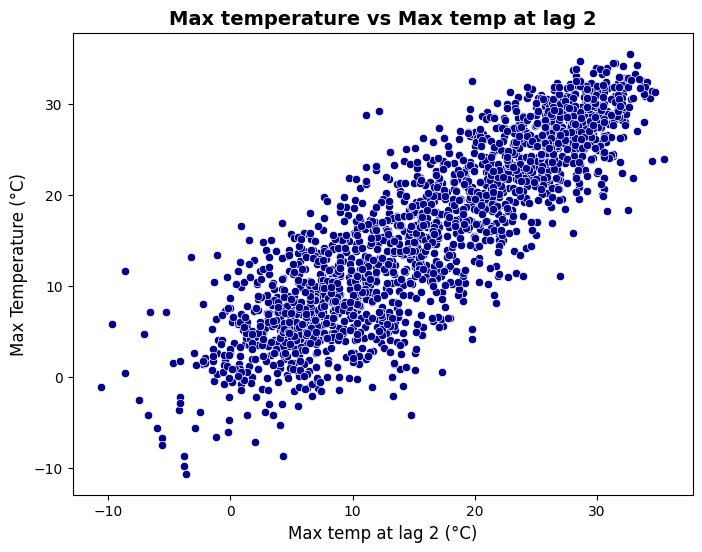

In [72]:
# Define plot size
plt.figure(figsize=(8, 6))

# Define data, axes and color
sns.scatterplot(data = df_train, x = "max_temp_lag2", 
                y = "max_temp", color = "darkblue")

# Add main title and format it
plt.title("Max temperature vs Max temp at lag 2", 
          fontsize=14, fontweight="bold", ha="center")

# Add axes titles and format them
plt.xlabel("Max temp at lag 2 (°C)", fontsize=12)
plt.ylabel("Max Temperature (°C)", fontsize=12)

# Display the plot
plt.show()

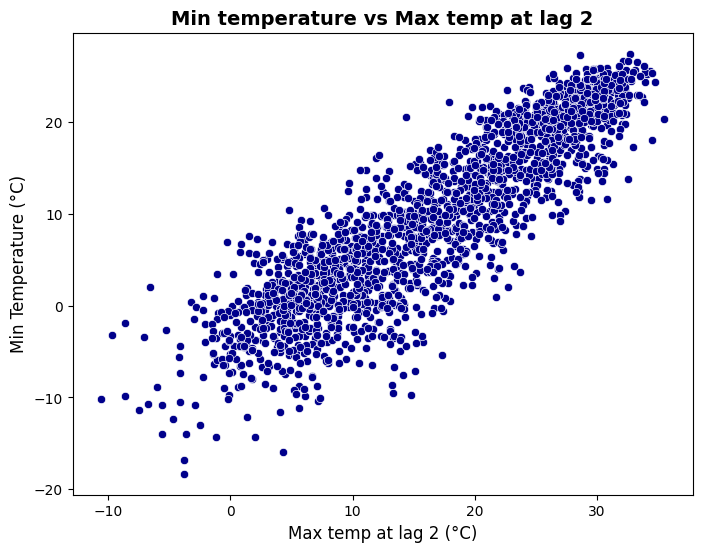

In [73]:
# Define plot size
plt.figure(figsize=(8, 6))

# Define data, axes and color
sns.scatterplot(data = df_train, x = "max_temp_lag2", 
                y = "min_temp", color = "darkblue")

# Add main title and format it
plt.title("Min temperature vs Max temp at lag 2", 
          fontsize=14, fontweight="bold", ha="center")

# Add axes titles and format them
plt.xlabel("Max temp at lag 2 (°C)", fontsize=12)
plt.ylabel("Min Temperature (°C)", fontsize=12)

# Display the plot
plt.show()

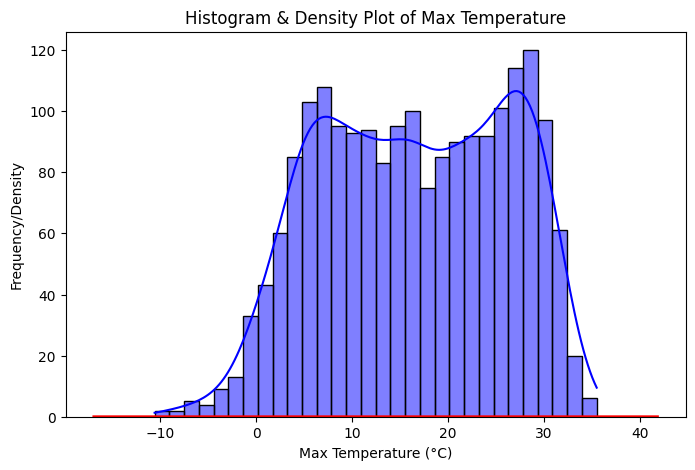

In [74]:
plt.figure(figsize=(8, 5))
sns.histplot(df_train["max_temp"], 
             bins=30, kde=True, color="blue", alpha=0.5)  
sns.kdeplot(df_train["max_temp"], color="red", linewidth=2)
plt.title("Histogram & Density Plot of Max Temperature")
plt.xlabel("Max Temperature (°C)")
plt.ylabel("Frequency/Density")
plt.show()

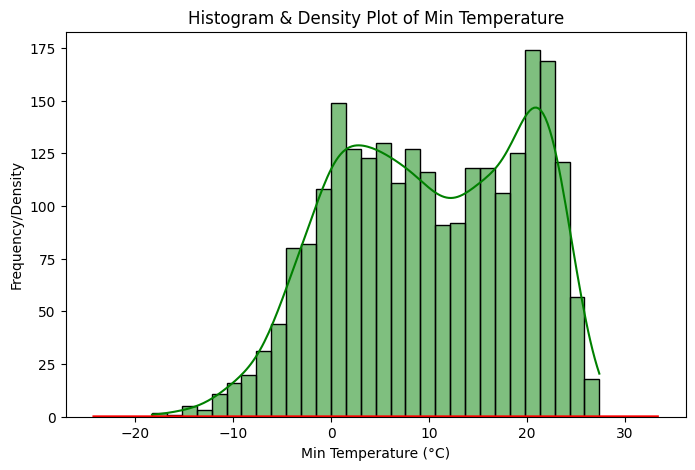

In [75]:
plt.figure(figsize=(8, 5))
sns.histplot(daily_df["min_temp"], 
             bins=30, kde=True, color="green", alpha=0.5)  
sns.kdeplot(daily_df["min_temp"], color="red", linewidth=2)  
plt.title("Histogram & Density Plot of Min Temperature")
plt.xlabel("Min Temperature (°C)")
plt.ylabel("Frequency/Density")
plt.show()

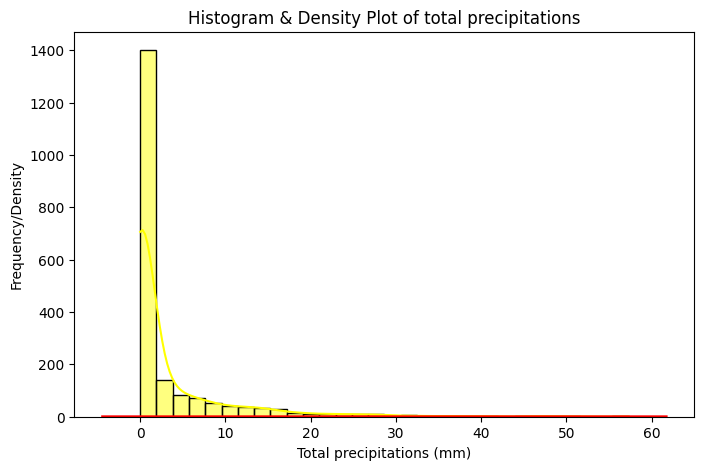

In [76]:
plt.figure(figsize=(8, 5))
sns.histplot(df_train["total_precip"], 
             bins=30, kde=True, color="yellow", alpha=0.5) 
sns.kdeplot(df_train["total_precip"], color="red", linewidth=2)  
plt.title("Histogram & Density Plot of total precipitations")
plt.xlabel("Total precipitations (mm)")
plt.ylabel("Frequency/Density")
plt.show()

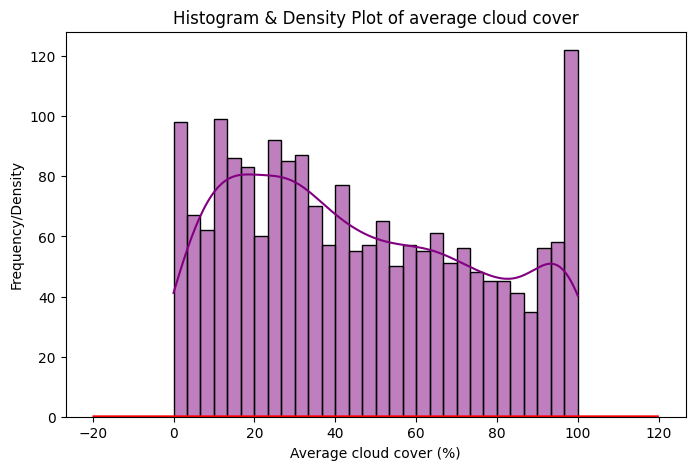

In [77]:
plt.figure(figsize=(8, 5))
sns.histplot(df_train["avg_cloudcover"], 
             bins=30, kde=True, color="purple", alpha=0.5)  
sns.kdeplot(df_train["avg_cloudcover"], color="red", linewidth=2)  
plt.title("Histogram & Density Plot of average cloud cover")
plt.xlabel("Average cloud cover (%)")
plt.ylabel("Frequency/Density")
plt.show()

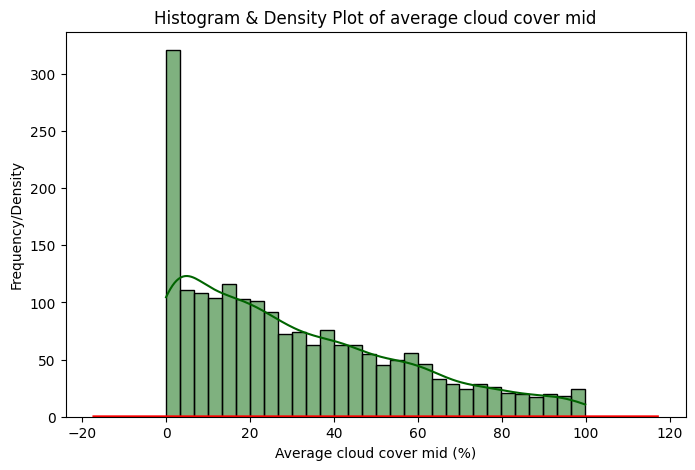

In [78]:
plt.figure(figsize=(8, 5))
sns.histplot(df_train["avg_cloudcover_mid"], 
             bins=30, kde=True, color="darkgreen", alpha=0.5)
sns.kdeplot(df_train["avg_cloudcover_mid"], color="red", linewidth=2)
plt.title("Histogram & Density Plot of average cloud cover mid")
plt.xlabel("Average cloud cover mid (%)")
plt.ylabel("Frequency/Density")
plt.show()

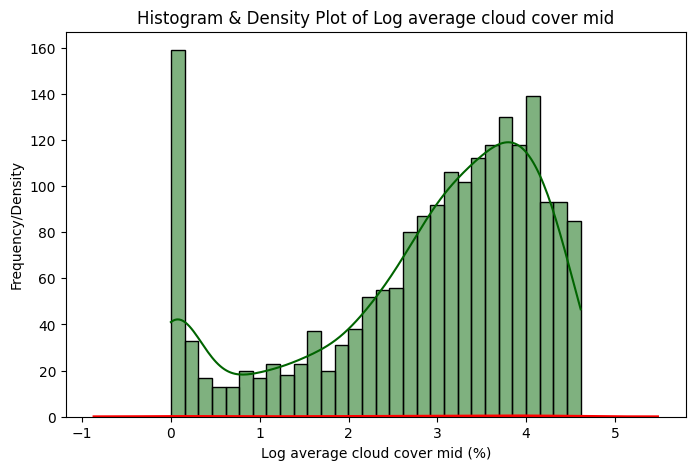

In [79]:
plt.figure(figsize=(8, 5))
sns.histplot(np.log1p(df_train["avg_cloudcover_mid"]), 
             bins=30, kde=True, color="darkgreen", alpha=0.5)  
sns.kdeplot(np.log1p(df_train["avg_cloudcover_mid"]), color="red", linewidth=2)
plt.title("Histogram & Density Plot of Log average cloud cover mid")
plt.xlabel("Log average cloud cover mid (%)")
plt.ylabel("Frequency/Density")
plt.show()

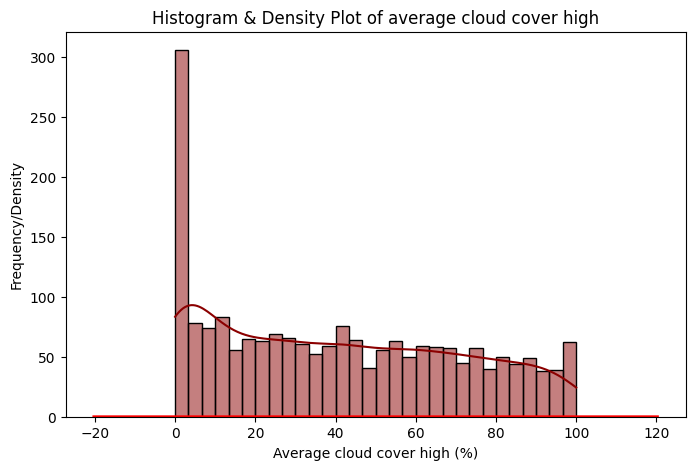

In [80]:
plt.figure(figsize=(8, 5))
sns.histplot(df_train["avg_cloudcover_high"], 
             bins=30, kde=True, color="darkred", alpha=0.5)  
sns.kdeplot(df_train["avg_cloudcover_high"], color="red", linewidth=2)  
plt.title("Histogram & Density Plot of average cloud cover high")
plt.xlabel("Average cloud cover high (%)")
plt.ylabel("Frequency/Density")
plt.show()

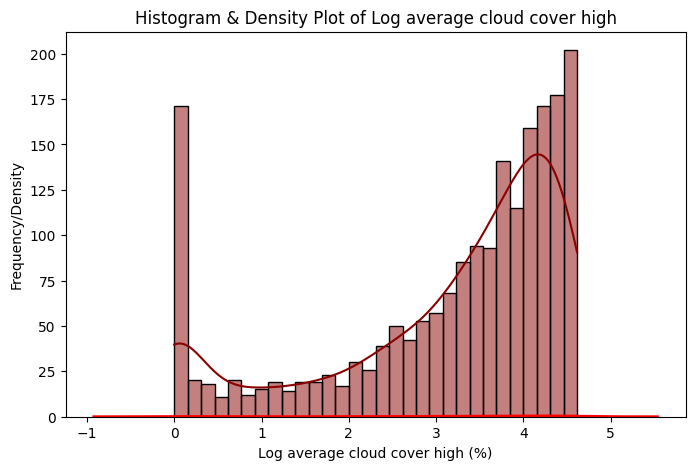

In [81]:
plt.figure(figsize=(8, 5))
sns.histplot(np.log1p(df_train["avg_cloudcover_high"]), 
             bins=30, kde=True, color="darkred", alpha=0.5)  
sns.kdeplot(np.log1p(df_train["avg_cloudcover_high"]), color="red", linewidth=2)  
plt.title("Histogram & Density Plot of Log average cloud cover high")
plt.xlabel("Log average cloud cover high (%)")
plt.ylabel("Frequency/Density")
plt.show()

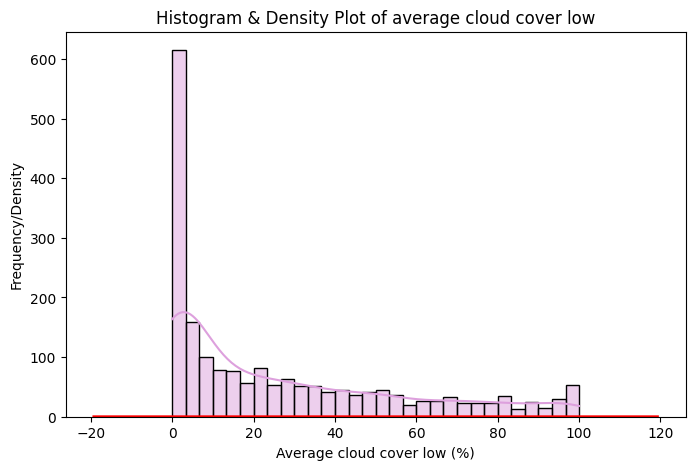

In [82]:
plt.figure(figsize=(8, 5))
sns.histplot(df_train["avg_cloudcover_low"], 
             bins=30, kde=True, color="plum", alpha=0.5)  
sns.kdeplot(df_train["avg_cloudcover_low"], color="red", linewidth=2)  
plt.title("Histogram & Density Plot of average cloud cover low")
plt.xlabel("Average cloud cover low (%)")
plt.ylabel("Frequency/Density")
plt.show()

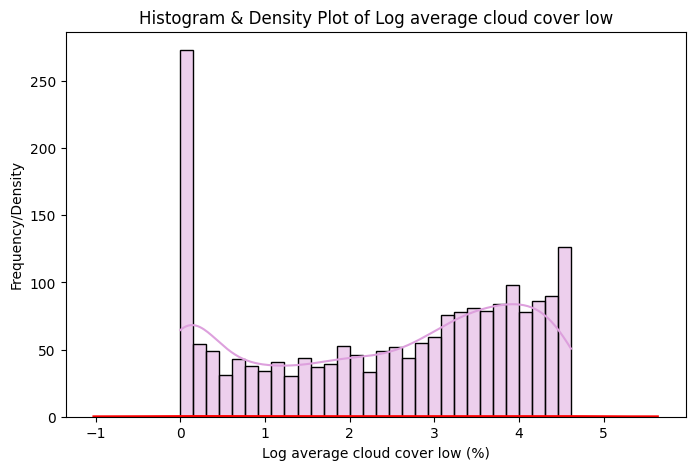

In [83]:
plt.figure(figsize=(8, 5))
sns.histplot(np.log1p(df_train["avg_cloudcover_low"]), 
             bins=30, kde=True, color="plum", alpha=0.5)  
sns.kdeplot(np.log1p(df_train["avg_cloudcover_low"]), color="red", linewidth=2)  
plt.title("Histogram & Density Plot of Log average cloud cover low")
plt.xlabel("Log average cloud cover low (%)")
plt.ylabel("Frequency/Density")
plt.show()

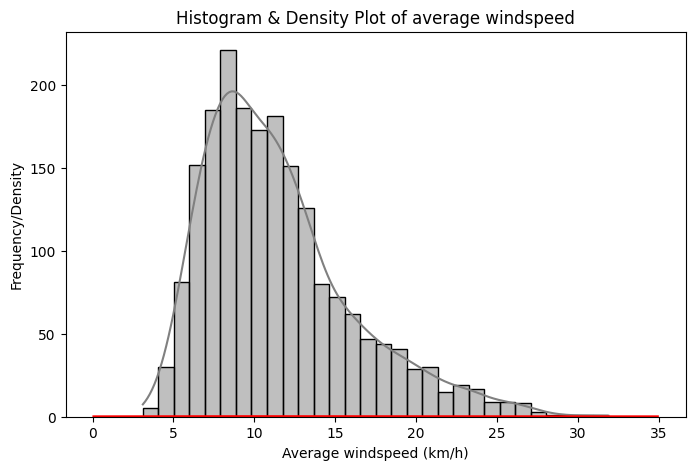

In [84]:
plt.figure(figsize=(8, 5))
sns.histplot(df_train["avg_windspeed"], 
             bins=30, kde=True, color="grey", alpha=0.5)  
sns.kdeplot(df_train["avg_windspeed"], color="red", linewidth=2)  
plt.title("Histogram & Density Plot of average windspeed")
plt.xlabel("Average windspeed (km/h)")
plt.ylabel("Frequency/Density")
plt.show()

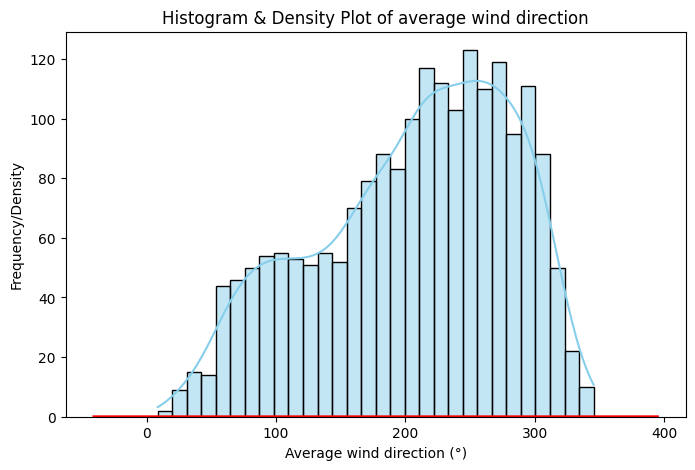

In [85]:
plt.figure(figsize=(8, 5))
sns.histplot(df_train["avg_winddirection"], 
             bins=30, kde=True, color="skyblue", alpha=0.5)  
sns.kdeplot(df_train["avg_winddirection"], color="red", linewidth=2)  
plt.title("Histogram & Density Plot of average wind direction")
plt.xlabel("Average wind direction (°)")
plt.ylabel("Frequency/Density")
plt.show()

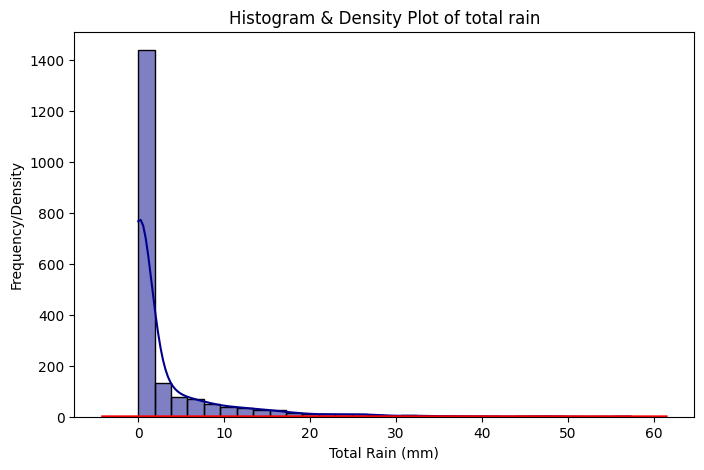

In [86]:
plt.figure(figsize=(8, 5))
sns.histplot(df_train["total_rain"], 
             bins=30, kde=True, color="darkblue", alpha=0.5)  
sns.kdeplot(df_train["total_rain"], color="red", linewidth=2)  
plt.title("Histogram & Density Plot of total rain")
plt.xlabel("Total Rain (mm)")
plt.ylabel("Frequency/Density")
plt.show()

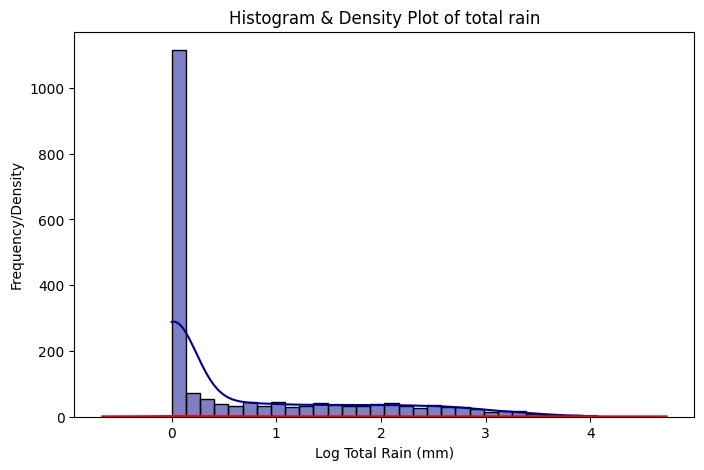

In [87]:
plt.figure(figsize=(8, 5))
sns.histplot(np.log1p(df_train["total_rain"]), 
             bins=30, kde=True, color="darkblue", alpha=0.5)  
sns.kdeplot(np.log1p(df_train["total_rain"]), color="red", linewidth=2) 
plt.title("Histogram & Density Plot of total rain")
plt.xlabel("Log Total Rain (mm)")
plt.ylabel("Frequency/Density")
plt.show()

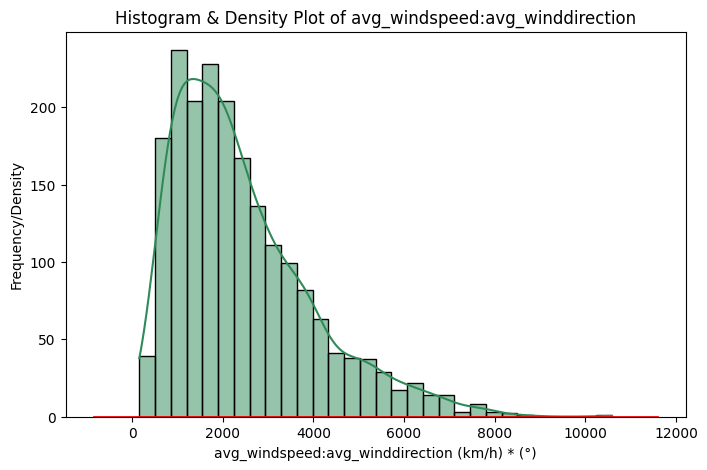

In [88]:
plt.figure(figsize=(8, 5))
sns.histplot(df_train["avg_windspeed"] * df_train["avg_winddirection"], 
             bins=30, kde=True, color="seagreen", alpha=0.5)  
sns.kdeplot(df_train["avg_windspeed"] * df_train["avg_winddirection"], color="red", linewidth=2) 
plt.title("Histogram & Density Plot of avg_windspeed:avg_winddirection")
plt.xlabel("avg_windspeed:avg_winddirection (km/h) * (°)")
plt.ylabel("Frequency/Density")
plt.show()

So far the most promising predictors are:

- max_temp (lag 2)
- min_temp (lag 2)
- max_temp (lag 1)
- min_temp (lag 1)
- avg_cloudcover_high
- avg_cloudcover_mid
- avg_cloudcover_low
- avg_windspeed
- avg_winddirection
- total_rain
- Log avg_cloudcover_high
- Log avg_cloudcover_mid
- Log avg_cloudcover_low
- Log total_rain

<br>

I could investigate further whether the log transformations for avg_cloudcover_low, avg_cloudcover_mid, avg_cloudcover_high and total_rain really have a better correlation with the target but since there are 14 targets, this would involve a lot of plots and the information might not be easy to summarize since hardly anyone can look at 14 plots and remember how they relate to each other.

To avoid overfitting, I will use a form of penalized regression paired with time series cross-validation. In this case Ridge regression will be used which adds a penalty term to the cost function for the model and ensures that predictors that are too weakly correlated to the targets get their coefficients shrunk to close to zero. 

In other words, I can include all the predictors listed, the non log transformed and their log transformed counterpart and let Ridge regression shrink the coefficients of the least relevant ones.

#### Step 6: Transformations

After performing exploratory data analysis and inspecting the histograms and density plots for different predictors, I noticed total_rain, avg_cloudcover_low, avg_cloudcover_mid and avg_cloudcover_high are right skewed and could potentially benefit from a log transformation to reduce skewness. As explained above, I will include the log transformed version of those predictors and let Ridge regression determine which predictor coefficients to shrink.

In [89]:
# Log transform the 3 predictors and create new columns for them on the training set
df_train["log_total_rain"] = np.log1p(df_train["total_rain"])
df_train["log_avg_cloudcover_low"] = np.log1p(df_train["avg_cloudcover_low"])
df_train["log_avg_cloudcover_mid"] = np.log1p(df_train["avg_cloudcover_mid"])
df_train["log_avg_cloudcover_high"] = np.log1p(df_train["avg_cloudcover_high"])

# Log transform the 3 predictors and create new columns for them on the testing set
df_test["log_total_rain"] = np.log1p(df_test["total_rain"])
df_test["log_avg_cloudcover_low"] = np.log1p(df_test["avg_cloudcover_low"])
df_test["log_avg_cloudcover_mid"] = np.log1p(df_test["avg_cloudcover_mid"])
df_test["log_avg_cloudcover_high"] = np.log1p(df_test["avg_cloudcover_high"])

# Additional interaction term
df_train["wind_momentum"] = df_train["avg_windspeed"] * df_train["avg_winddirection"]
df_test["wind_momentum"] = df_test["avg_windspeed"] * df_test["avg_winddirection"]

#### Step 7: Training the model

Next I decide to train the model using the predictors listed above.

In [90]:
# First I separate the targets from the predictors
feature_cols = [
    "max_temp_lag1", "max_temp_lag2", 
    "min_temp_lag1", "min_temp_lag2",
    "avg_cloudcover_low", "avg_cloudcover_mid", "avg_cloudcover_high",
    "log_avg_cloudcover_low", "log_avg_cloudcover_mid", "log_avg_cloudcover_high", 
    "avg_windspeed", "avg_winddirection", "wind_momentum", 
    "total_rain", "log_total_rain"
]

target_cols = ["min_temp", "max_temp",
               "min_temp_tplus1", "max_temp_tplus1",
               "min_temp_tplus2", "max_temp_tplus2",
               "min_temp_tplus3", "max_temp_tplus3",
               "min_temp_tplus4", "max_temp_tplus4",
               "min_temp_tplus5", "max_temp_tplus5",
               "min_temp_tplus6", "max_temp_tplus6"]

# Split the training set into predictors and targets
X_train = df_train[feature_cols]
y_train = df_train[target_cols]

# Split the testing set into predictors and targets
X_test = df_test[feature_cols]
y_test = df_test[target_cols]

In [91]:
# List of alpha values to try (higher = more regularization)
alphas = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0]

# Create a time-aware cross-validation strategy
tscv = TimeSeriesSplit(gap = 7, n_splits = 7, test_size = 7)

# Create model pipeline
model = make_pipeline(
    StandardScaler(),
    RidgeCV(alphas=alphas, cv=tscv)
)

# Train the model
model.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('ridgecv',
                 RidgeCV(alphas=[0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0],
                         cv=TimeSeriesSplit(gap=7, max_train_size=None, n_splits=7, test_size=7)))])

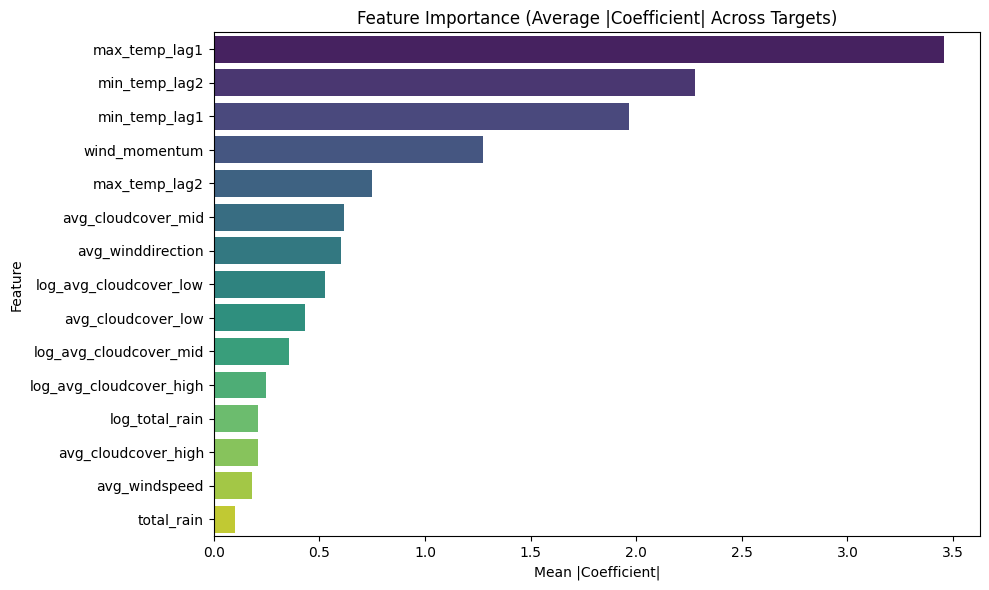

In [92]:
# Extract coefficients 
coefs = pd.DataFrame(
    model.named_steps["ridgecv"].coef_.T,  # transpose to get features as rows
    index=X_train.columns,                 # rows = features
    columns=y_train.columns               # columns = targets
)

# Compute mean absolute importance per feature
mean_importance = coefs.abs().mean(axis=1).sort_values(ascending=False)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(
    x=mean_importance.values,
    y=mean_importance.index,
    hue=mean_importance.index,
    dodge=False,
    palette=sns.color_palette("viridis", n_colors=len(mean_importance)),
    legend=False
)
plt.title("Feature Importance (Average |Coefficient| Across Targets)")
plt.xlabel("Mean |Coefficient|")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

Looking at the bargraph above, I can see that the feature importance across all 14 targets. In order not to have redundant predictors that make coefficient interpretations more complicated. I opt to use:

- max_temp (lag 1)
- max_temp (lag 2)
- min_temp (lag 1)
- min_temp (lag 2)
- wind_momentum
- avg_winddirection
- avg_windspeed
- avg_cloudcover_mid
- log_avg_cloudcover_low
- log_avg_cloudcover_high
- log_total_rain

<br>

After manual feature pruning based on domain insight, I can then train a second model with a ridge regression but without avg_cloudcover_low, avg_cloudcover_high, and total_rain

In [ ]:
# Create the second model after removing redundant predictors
feature_cols_mod2 = [
    "max_temp_lag1", "max_temp_lag2", 
    "min_temp_lag1", "min_temp_lag2",
    "avg_cloudcover_mid", "log_avg_cloudcover_low", "log_avg_cloudcover_high", 
    "avg_windspeed", "avg_winddirection", "wind_momentum", 
    "log_total_rain"
]

target_cols_mod2 = ["min_temp", "max_temp",
               "min_temp_tplus1", "max_temp_tplus1",
               "min_temp_tplus2", "max_temp_tplus2",
               "min_temp_tplus3", "max_temp_tplus3",
               "min_temp_tplus4", "max_temp_tplus4",
               "min_temp_tplus5", "max_temp_tplus5",
               "min_temp_tplus6", "max_temp_tplus6"]

# Uncomment to download final training set with all engineered features
# Extracting training set for report
# df_train_report = df_train[feature_cols_mod2 + target_cols_mod2]
# model_training_set_report = "nyc_weather_model_training_set.csv"
# df_train_report.to_csv(model_training_set_report, index=False)

# Split the training set into predictors and targets
X_train_mod2 = df_train[feature_cols_mod2]
y_train_mod2 = df_train[target_cols_mod2]

# Split the testing set into predictors and targets
X_test_mod2 = df_test[feature_cols_mod2]
y_test_mod2 = df_test[target_cols_mod2]

# Create model pipeline
model2 = make_pipeline(
    StandardScaler(),
    RidgeCV(alphas=alphas, cv=tscv)
)

# Train the model
model2.fit(X_train_mod2, y_train_mod2)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('ridgecv',
                 RidgeCV(alphas=[0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0],
                         cv=TimeSeriesSplit(gap=7, max_train_size=None, n_splits=7, test_size=7)))])

In [94]:
# Make predictions on the testing set
y_pred = model2.predict(X_test_mod2)

# Collect RMSE values and Standard deviation values for all targets
target_columns = y_test_mod2.columns 
rmse_values = []
r2_scores = []

# Compute all rmse values
for i, col in enumerate(target_columns):
    rmse = root_mean_squared_error(y_test_mod2[col], y_pred[:, i])
    rmse_values.append(rmse)

# Compute all r2 scores
for i, col in enumerate(target_columns):
    score = r2_score(y_test_mod2[col], y_pred[:, i])
    r2_scores.append(score)

n = X_test_mod2.shape[0] # Number of observations
p = X_test_mod2.shape[1] # Number of predictors
adj_r2_scores = []

# Compute all adjusted r2 scores
for score in r2_scores:
    adj_r2 = 1 - (1 - score) * (n - 1) / (n - p - 1)
    adj_r2_scores.append(adj_r2)

# Compute all standard deviations    
std_values = [y_test_mod2[col].std() for col in target_columns]

# Print RMSE vs Standard deviation for each target
for i, col in enumerate(target_columns):
    print(f"{col}: RMSE: {rmse_values[i]:.2f} Std: {std_values[i]:.2f}")


min_temp: RMSE: 2.70 Std: 9.50
max_temp: RMSE: 3.15 Std: 9.45
min_temp_tplus1: RMSE: 3.73 Std: 9.50
max_temp_tplus1: RMSE: 4.23 Std: 9.44
min_temp_tplus2: RMSE: 4.03 Std: 9.49
max_temp_tplus2: RMSE: 4.41 Std: 9.42
min_temp_tplus3: RMSE: 4.05 Std: 9.49
max_temp_tplus3: RMSE: 4.37 Std: 9.41
min_temp_tplus4: RMSE: 4.11 Std: 9.48
max_temp_tplus4: RMSE: 4.37 Std: 9.40
min_temp_tplus5: RMSE: 4.24 Std: 9.47
max_temp_tplus5: RMSE: 4.48 Std: 9.39
min_temp_tplus6: RMSE: 4.35 Std: 9.46
max_temp_tplus6: RMSE: 4.57 Std: 9.39


#### Step 8: Results and potential improvements

Below I created visualizations to compare the root mean squared error and the standard deviation for each of the targets in the testing set.

The results are discussed below the visualizations.

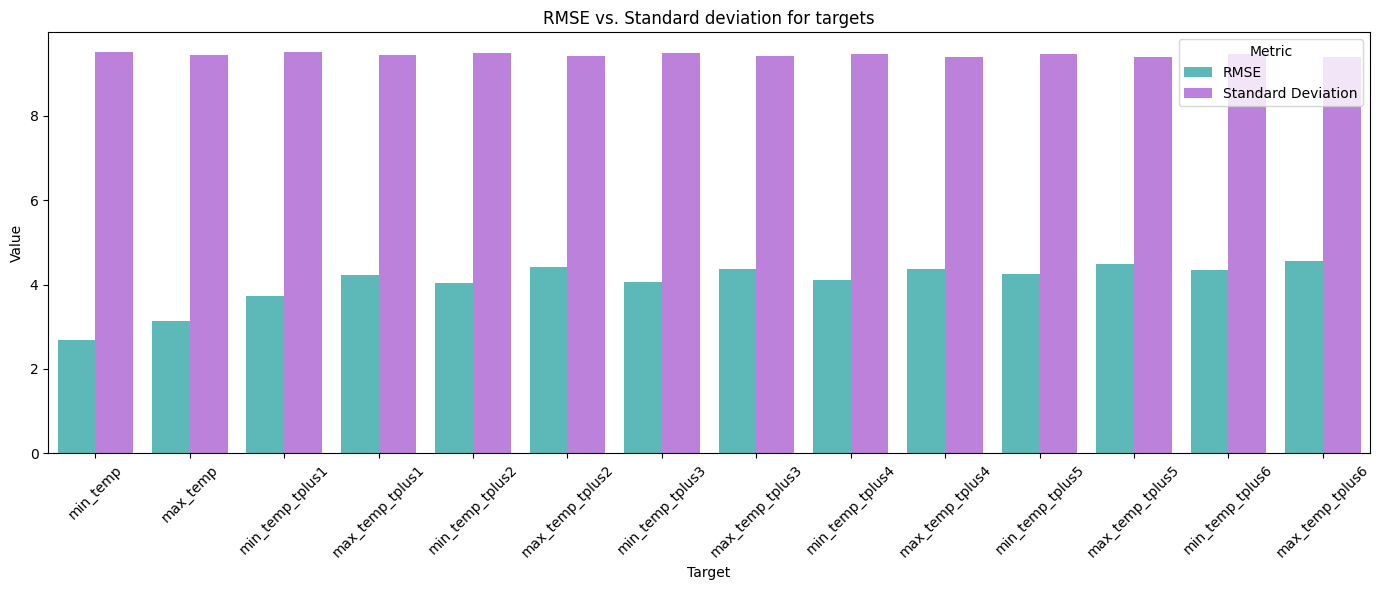

In [95]:
# Create dataframe for plotting results
plot_df = pd.DataFrame({
    "Target": list(target_columns) * 2,
    "Metric": ["RMSE"] * len(rmse_values) + ["Standard Deviation"] * len(std_values),
    "Value": rmse_values + std_values
})

# Color palette
custom_palette = {
    "RMSE": "#4ec8c6",               
    "Standard Deviation": "#bf72ea"
}

# Plot
plt.figure(figsize=(14, 6))
sns.barplot(data=plot_df, x="Target", y="Value", hue="Metric", palette=custom_palette)
plt.title("RMSE vs. Standard deviation for targets")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [96]:
# Summary statistics

mean_rmse = np.mean(rmse_values)
mean_std = np.mean(std_values)
mean_adj_r2 = np.mean(adj_r2_scores)

print("Summary Statistics: \n")
print(f"Mean RMSE Score: {mean_rmse:.2f}")
print(f"Mean Adjusted R2 Score: {mean_adj_r2:.2f}")
print(f"RMSE percent of Standard deviation: {((mean_rmse / mean_std) * 100):.2f}")

Summary Statistics: 

Mean RMSE Score: 4.06
Mean Adjusted R2 Score: 0.81
RMSE percent of Standard deviation: 42.92


<u>Summary of results</u>

Considering weather data is notoriously difficult to predict, and the fact that Stanford University researchers acheived a mean RMSE score of: 5.36 (on a Fahrenheit scale), I deem the results of this study to be satisfactory since they are only marginally worse with a mean RMSE score of: 4.06 (7.31 adjusted for Fahrenheit scale) and an adjusted R2 score of: 0.81.

<br>

<u>Potential improvements</u>

Methods that were used to attempt to optimize this model included utilizing time series cross validation folds, penalized regression (Ridge), performing log transformations on 4 potential predictors and feature engineering an interaction term between avg_windspeed and avg_winddirection. To select between the log-transformed predictor and its non log-transformed counterpart, I performed manual feature pruning by computing the mean coefficient (absolute value) across all targets for each of the potential predictors.

Other modeling techniques that could be investigated to improve the model involve:

- Adding more lagged terms to this type of model
- Exploring other types of models such as ARIMAX, GAMs, or tree based models like Random Forest or XgBoost